In [1]:
import os, collections

if not os.path.exists('CIFAR10_data'):
    
    !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
    !mkdir CIFAR10_data
    !tar -xf cifar-10-python.tar.gz -C CIFAR10_data

if not os.path.exists('CIFAR10_mask'):
    
    !tar -xf CIFAR10_mask.tar

from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image
import cv2

from utils import unpickle, batch_run, preprocess
from deepexplain.tensorflow import DeepExplain
from models import CIFAR_CNN

datadir = 'CIFAR10_data/cifar-10-batches-py/'
batches_train = sorted([datadir + batch for batch in os.listdir(datadir) if 'data_batch' in batch], key=lambda x: int(x[-1]))
batch_test = datadir + 'test_batch'

logdir = 'tf_logs/standard/'

In [2]:
for i in tqdm(range(5)):
    
    batch = unpickle(batches_train[i])

    if i == 0:
        data = batch[b'data'].astype(np.float32)
        cifar = np.transpose(np.reshape(data, [-1,3,32,32]), [0,2,3,1])
        labels = batch[b'labels']
    else:
        data = batch[b'data'].astype(np.float32)
        cifar = np.concatenate((cifar, np.transpose(np.reshape(data, [-1,3,32,32]), [0,2,3,1])), axis=0)
        labels = np.concatenate((labels, batch[b'labels']), axis=0)

test_batch = unpickle(batch_test)
cifar_test = np.transpose(np.reshape(test_batch[b'data'], [-1,3,32,32]), [0,2,3,1])
labels_test = np.array(test_batch[b'labels'])

data_train = (cifar / 127.5 - 1.0, labels)
data_test = (cifar_test / 127.5 - 1.0, labels_test)

100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


In [3]:
def load_images(img_dir, img_size=(32,32)):
    
    def file_number(x):
        
        return int(x.split('.')[0].split('_')[1])
    
    filenames = os.listdir(img_dir)
    
    image_files = {}
    mask_files = {}
    
    images = {}
    masks = {}
    
    for file in filenames:
        
        cls = file.split('_')[0]
        is_mask = 'mask' in file
        
        if is_mask:
            
            if cls in mask_files:
                mask_files[cls].append(file)
            else:
                mask_files[cls] = [file]
                
            mask_files[cls] = sorted(mask_files[cls], key=file_number)
        
        else:
            
            if cls in image_files:
                image_files[cls].append(file)
            else:
                image_files[cls] = [file]
            
            image_files[cls] = sorted(image_files[cls], key=file_number)
    
    for k, v in image_files.items():
        
        res = []
        
        for file in v:
            image = PIL.Image.open(img_dir + file)
            image = np.array(image.resize(img_size, PIL.Image.ANTIALIAS)).reshape(1,32,32,-1)
            res.append(image)
        
        res = np.concatenate(res, axis=0)[...,::-1]
        res = res / 127.5 - 1.0
        images[k] = res
    
    for k, v in mask_files.items():
        
        res = []
        
        for file in v:
            image = PIL.Image.open(img_dir + file)
            image = np.array(image.resize(img_size, PIL.Image.ANTIALIAS)).reshape(1,32,32,-1)
            res.append(image)
        
        res = np.concatenate(res, axis=0)
        masks[k] = res
    
    return images, masks

label_map = {0:'Airplane', 1:'Automobile', 2:'Bird', 3:'Cat', 4:'Deer', 5:'Dog', 6:'Frog', 7:'Horse', 8:'Ship', 9:'Truck'}
class_map = {v.lower(): k for k, v in label_map.items()}

## Attribution Outside Mask

INFO:tensorflow:Restoring parameters from tf_logs/standard/model
Running RectGrad explanation method
Running RectGrad PRR explanation method
Running Saliency Map explanation method
Running Guided BP explanation method
Running SmoothGrad explanation method
Running Gradient * Input explanation method
Running IntegGrad explanation method
Running DeepLIFT explanation method
Done!


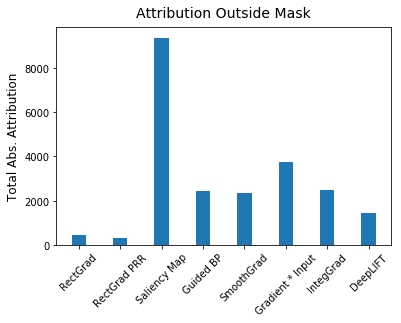

In [4]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

with DeepExplain(session=sess, graph=sess.graph) as de:

    new_saver = tf.train.import_meta_graph(logdir + 'model.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

    X = tf.get_collection('tensors')[0]
    logits = tf.get_collection('tensors')[1]
    yv = tf.reduce_max(logits, 1)
    yi = tf.argmax(logits, 1)

    images, masks = load_images('CIFAR10_mask/')

    for k, v in images.items():
        predictions = sess.run(yi, feed_dict={X:v})
        correct_inds = np.where(predictions == class_map[k])
        images[k] = images[k][correct_inds]
        masks[k] = masks[k][correct_inds]

    xs = np.concatenate([v[:10] for k, v in sorted(images.items())])
    ms = np.concatenate([v[:10] < 200 for k, v in sorted(masks.items())])
    
    attribution_methods = [
                           ('RectGrad'         , 'rectgrad'),
                           ('RectGrad PRR'     , 'rectgradprr'),
                           ('Saliency Map'     , 'saliency'),
                           ('Guided BP'        , 'guidedbp'),
                           ('SmoothGrad'       , 'smoothgrad'),
                           ('Gradient * Input' , 'grad*input'),
                           ('IntegGrad'        , 'intgrad'),
                           ('DeepLIFT'         , 'deeplift')
                          ]

    attribution_methods = collections.OrderedDict(attribution_methods)
    
    attributions = collections.OrderedDict()
    
    for k, v in attribution_methods.items():
        
        print('Running {} explanation method'.format(k))
        
        attribution = de.explain(v, yv, X, xs)
        
        if 'RectGrad' in k:
            attribution = np.where(attribution > 0, attribution, 0.0)
            attributions[k] = preprocess(attribution, 0, 100)
        else:
            attributions[k] = preprocess(attribution, 95, 100)
    
    print('Done!')

sess.close()

res = []

for k, v in attributions.items():
    
    res.append(np.sum(ms * np.abs(v)[...,None]))

plt.figure()
plt.bar(np.arange(8), res, 0.35)
plt.xticks(np.arange(8), attributions.keys(), rotation=45, ha='center')
plt.title('Attribution Outside Mask', fontsize=14, pad=10)
plt.ylabel('Total Abs. Attribution', fontsize=12)
plt.show()

## Total Variation

INFO:tensorflow:Restoring parameters from tf_logs/standard/model
Running RectGrad explanation method
Running RectGrad PRR explanation method
Running Saliency Map explanation method
Running Guided BP explanation method
Running SmoothGrad explanation method
Running Gradient * Input explanation method
Running IntegGrad explanation method
Running DeepLIFT explanation method
Done!


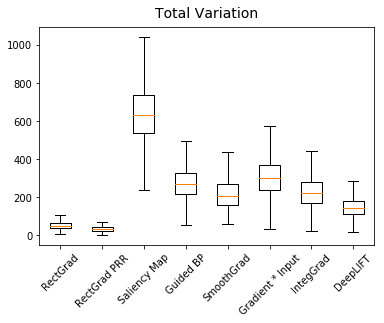

In [5]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

with DeepExplain(session=sess, graph=sess.graph) as de:

    new_saver = tf.train.import_meta_graph(logdir + 'model.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

    X = tf.get_collection('tensors')[0]
    logits = tf.get_collection('tensors')[1]
    yv = tf.reduce_max(logits, 1)
    yi = tf.argmax(logits, 1)
    
    heavy_methods = ['SmoothGrad', 'IntegGrad', 'DeepLIFT']
    
    attribution_methods = [
                           ('RectGrad'         , 'rectgrad'),
                           ('RectGrad PRR'     , 'rectgradprr'),
                           ('Saliency Map'     , 'saliency'),
                           ('Guided BP'        , 'guidedbp'),
                           ('SmoothGrad'       , 'smoothgrad'),
                           ('Gradient * Input' , 'grad*input'),
                           ('IntegGrad'        , 'intgrad'),
                           ('DeepLIFT'         , 'deeplift')
                          ]

    attribution_methods = collections.OrderedDict(attribution_methods)
    
    attributions = collections.OrderedDict()
    
    for k, v in attribution_methods.items():
        
        if k in heavy_methods:
            batch_size = 500
        else:
            batch_size = 1000
        
        print('Running {} explanation method'.format(k))
        
        attribution = batch_run(lambda x: de.explain(v, yv, X, x), data_train[0], batch_size)
        
        if 'RectGrad' in k:
            attribution = np.where(attribution > 0, attribution, 0.0)
            attributions[k] = preprocess(attribution, 0, 100)
        else:
            attributions[k] = preprocess(attribution, 95, 100)
    
    print('Done!')

attrs = tf.placeholder(tf.float32, [None,32,32,1])
tv_loss = tf.image.total_variation(attrs)

noise = [sess.run(tv_loss, feed_dict={attrs: v[...,None]}) for v in attributions.values()]

sess.close()

plt.figure()
plt.boxplot(noise, showfliers=False)
plt.xticks(np.arange(1, 9), attributions.keys(), rotation=45, ha='center')
plt.title('Total Variation', fontsize=14, pad=10)
plt.show()